In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, tqdm
import os
import matplotlib.patches as patches
pd.set_option('max_columns', 100)
#from kaggle.competitions import nflrush
from sklearn.model_selection import KFold, RepeatedKFold
import math
#note： 
#1. As a result it might not be worthwhile to use features related to game clock/quarter of the game。
#2. There is no relationships between number of rushes before and running yards gained。
#3. rushing success larger depends on defender in box, or defender that are close to offensive lineman and attempt 
#   to counter the blocking.
#4. highly drafted player has the same average rushing yards as the rest
#ARI: Arizona Cardinals
#ATL: Atlanta Falcons
#BAL: Baltimore Ravens
#BUF: Buffalo Bills
#CAR: Carolina Panthers
#CHI: Chicago Bears
#CIN: Cincinnati Bengals
#CLE: Cleveland Browns
#DAL: Dallas Cowboys
#DEN: Denver Broncos
#DET: Detroit Lions
#GB: Green Bay Packers
#HOU: Houston Texans
#IND: Indianapolis Colts
#JAX: Jacksonville Jaguars
#KC: Kansas City Chiefs
#MIA: Miami Dolphins
#MIN: Minnesota Vikings
#NE: New England Patriots
#NO: New Orleans Saints
#NYG: New York Giants
#NYJ: New York Jets
#OAK: Oakland Raiders
#PHI: Philadelphia Eagles
#PIT: Pittsburgh Steelers
#SD: San Diego Chargers
#SEA: Seattle Seahawks
#SF: San Francisco 49ers
#STL: Saint Louis Rams
#TB: Tampa Bay Buccaneers
#TEN Tennessee Titans
#WAS: Washington Redskins

In [87]:
train_df = pd.read_csv(r'C:\Users\38980\OneDrive\Desktop\study\kaggle\NFL\train.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
train_df.shape

(509762, 49)

In [89]:
# Yards is the target
# difference between Orientation and Dir?
#
# convert GameClock,'TimeHandoff','TimeSnap' to time ,and create new feature time to end
# HomeScoreBeforePlay - VisitorScoreBeforePlay will determine strategy
# break OffensePersonnel and DefensePersonnel into several columns
# StadiumType includes similiar types
# FieldPosition is nan means two team start at middle line
# cencored data because yards is smaller than total yards to endzone. 14562 touchdown
# total number of try in each game and player
train_df.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerWeight,Week,Temperature,Humidity
count,5.097620e+05,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509744.000000,509748.000000,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,5.097620e+05,509696.000000,509762.000000,509762.000000,509762.000000,461230.000000,503602.000000
mean,2.017594e+09,2.017594e+13,60.040304,26.783535,2.591912,1.683176,0.279406,180.247779,179.933859,2.344703e+06,54.187982,2017.486427,28.368737,2.504639,1.520651,8.329248,11.148073,9.501057,2.419204e+06,6.943025,4.212334,253.554388,9.096370,60.436442,55.646062
std,4.997098e+05,4.997098e+09,25.435261,7.238206,1.383601,0.976412,0.145482,104.298330,106.319488,6.418871e+05,28.379359,0.499816,13.010918,1.144105,0.674987,3.795208,10.277098,9.366413,5.357783e+05,0.991130,6.436167,48.367386,5.000984,17.570291,25.430976
min,2.017091e+09,2.017091e+13,0.660000,1.850000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000e+02,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.340000e+02,1.000000,-14.000000,153.000000,1.000000,9.000000,0.000000
25%,2.017111e+09,2.017111e+13,39.090000,22.730000,1.500000,0.940000,0.170000,90.630000,89.830000,2.532865e+06,26.000000,2017.000000,20.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.540011e+06,6.000000,1.000000,210.000000,5.000000,48.000000,43.000000
50%,2.017123e+09,2.017123e+13,60.290000,26.790000,2.470000,1.540000,0.270000,179.700000,180.090000,2.543765e+06,56.000000,2017.000000,29.000000,3.000000,1.000000,10.000000,9.000000,7.000000,2.552582e+06,7.000000,3.000000,245.000000,9.000000,62.000000,59.000000
75%,2.018110e+09,2.018110e+13,80.970000,30.860000,3.560000,2.290000,0.390000,270.400000,270.190000,2.555343e+06,78.000000,2018.000000,39.000000,4.000000,2.000000,10.000000,17.000000,14.000000,2.557976e+06,8.000000,6.000000,305.000000,14.000000,73.000000,71.000000
max,2.018123e+09,2.018123e+13,116.840000,56.450000,9.410000,14.710000,1.390000,360.000000,360.000000,2.561671e+06,99.000000,2018.000000,50.000000,5.000000,4.000000,40.000000,57.000000,51.000000,2.561468e+06,11.000000,99.000000,380.000000,17.000000,97.000000,100.000000


In [91]:
# FieldPosition is nan means two team start at middle line
#cencored data because yards is smaller than total yards to endzone
train_df.isnull().sum()

GameId                        0
PlayId                        0
Team                          0
X                             0
Y                             0
S                             0
A                             0
Dis                           0
Orientation                  18
Dir                          14
NflId                         0
DisplayName                   0
JerseyNumber                  0
Season                        0
YardLine                      0
Quarter                       0
GameClock                     0
PossessionTeam                0
Down                          0
Distance                      0
FieldPosition              6424
HomeScoreBeforePlay           0
VisitorScoreBeforePlay        0
NflIdRusher                   0
OffenseFormation            110
OffensePersonnel              0
DefendersInTheBox            66
DefensePersonnel              0
PlayDirection                 0
TimeHandoff                   0
TimeSnap                      0
Yards   

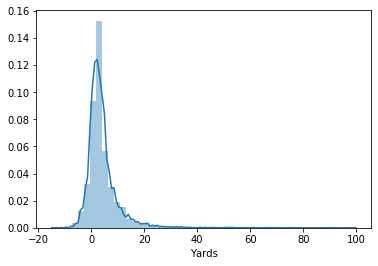

In [92]:
# distribution of target label
sns.distplot(train_df['Yards'])
plt.show()

In [93]:
train_df[train_df['FieldPosition'].isnull()][['FieldPosition','PossessionTeam','Yards']].max()

FieldPosition     None
PossessionTeam     WAS
Yards               50
dtype: object

In [94]:
# max yards
def max_yards(df):
    if df["FieldPosition"] == df["PossessionTeam"]:
        maxrun = 100 - df["YardLine"]
    else:
        maxrun = df["YardLine"]
    return maxrun

In [95]:
train_df['max_run'] = train_df.apply(max_yards, axis = 1)

In [96]:
 def give_me_WindSpeed(x):
        x = str(x)
        x = x.replace('mph', '').strip()
        if '-' in x:
            x = (int(x.split('-')[0]) + int(x.split('-')[1])) / 2
        elif 'gusts up to' in x:
            x = (int(x.split()[0]) + int(x.split()[-1])) / 2
        elif 'clam' in x:
            x = 0
        try:
            return float(x)
        except:
            return -99

In [97]:
train_df['Cleaned_WindSpeed'] = train_df['WindSpeed'].apply(give_me_WindSpeed)

In [98]:
train_df['Cleaned_TimeHandoff'] = train_df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
train_df['Cleaned_TimeSnap'] = train_df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
train_df['Cleaned_PlayerBirthDate'] = train_df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

In [99]:
#player age
seconds_in_year = 60*60*24*365.25
train_df['PlayerAge'] = train_df.apply(lambda row: (row['Cleaned_TimeHandoff']-row['Cleaned_PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)

In [100]:
train_df['Cleaned_PlayerHeight'] = train_df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

In [101]:
#team abbreviations correct
train_df.loc[train_df['PossessionTeam'] == 'ARZ', 'PossessionTeam'] = 'ARI'
train_df.loc[train_df['PossessionTeam'] == 'BLT', 'PossessionTeam'] = 'BAL'
train_df.loc[train_df['PossessionTeam'] == 'CLV', 'PossessionTeam'] = 'CLE'
train_df.loc[train_df['PossessionTeam'] == 'HST', 'PossessionTeam'] = 'HOU'
train_df.loc[train_df['FieldPosition'] == 'ARZ', 'PossessionTeam'] = 'ARI'
train_df.loc[train_df['FieldPosition'] == 'BLT', 'PossessionTeam'] = 'BAL'
train_df.loc[train_df['FieldPosition'] == 'CLV', 'PossessionTeam'] = 'CLE'
train_df.loc[train_df['FieldPosition'] == 'HST', 'PossessionTeam'] = 'HOU'

In [102]:
#Turf
Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 
train_df['Cleaned_Turf'] = train_df['Turf'].map(Turf)

In [103]:
#fix weather
train_df['Cleaned_GameWeather'] = train_df['GameWeather'].str.lower()
indoor = "indoor"
train_df['Cleaned_GameWeather'] = train_df['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
train_df['Cleaned_GameWeather'] = train_df['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
train_df['Cleaned_GameWeather'] = train_df['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
train_df['Cleaned_GameWeather'] = train_df['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)

In [104]:
train_df['ToLeft'] = train_df.PlayDirection == "left"
train_df['IsBallCarrier'] = train_df.NflId == train_df.NflIdRusher

In [105]:
def get_dx_dy(angle, dist):
    radian_angle = (90 - angle)* math.pi/180.0
    dx = dist * math.cos(radian_angle)
    dy = dist * math.sin(radian_angle)
    return dx, dy

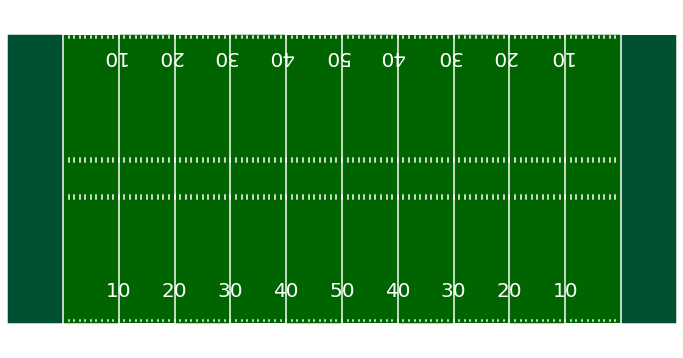

In [106]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()
plt.show()

In [107]:
def show_play(play_id, train=train_df):
    df = train_df[train_df.PlayId == play_id]
    fig, ax = create_football_field()
    ax.scatter(df.X, df.Y, cmap='rainbow', c=df.Team == 'home')
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X, rusher_row.Y, color='black')
    yards_covered = rusher_row["Yards"].values[0]

    x = rusher_row["X"].values[0]
    y = rusher_row["Y"].values[0]
    rusher_dir = rusher_row["Dir"].values[0]
    rusher_speed = rusher_row["S"].values[0]
    dx, dy = get_dx_dy(rusher_dir, rusher_speed)

    ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color='black')
    plt.title(f'Play # {play_id} and yard distance is {yards_covered}', fontsize=20)
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


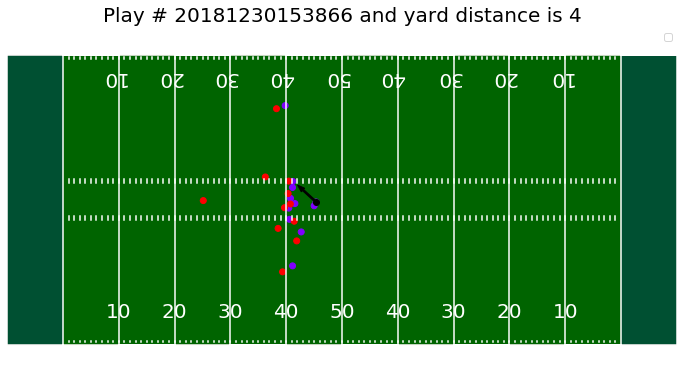

No handles with labels found to put in legend.


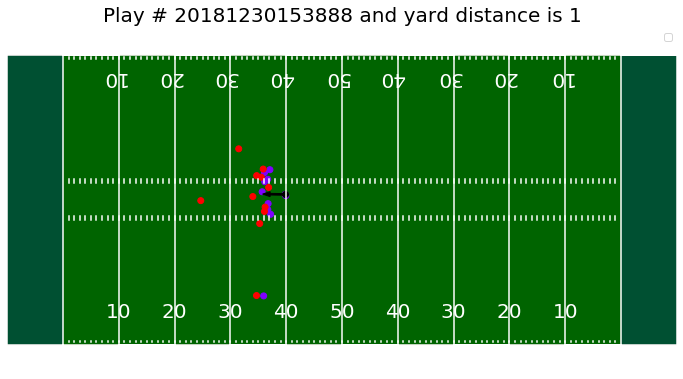

No handles with labels found to put in legend.


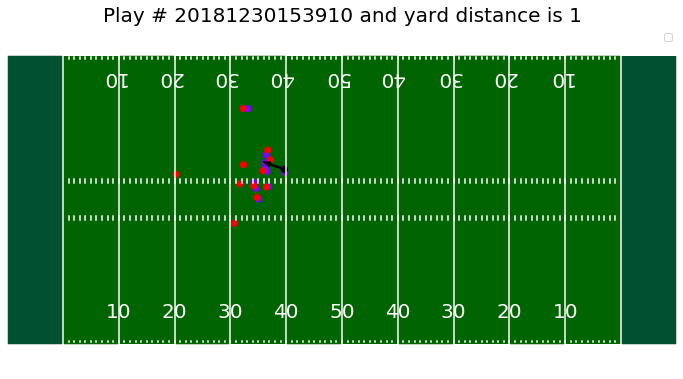

No handles with labels found to put in legend.


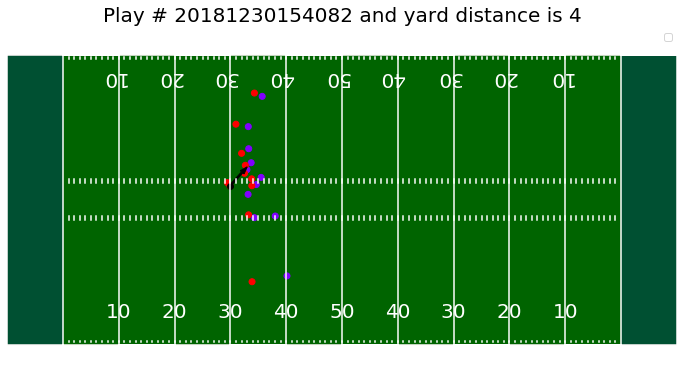

No handles with labels found to put in legend.


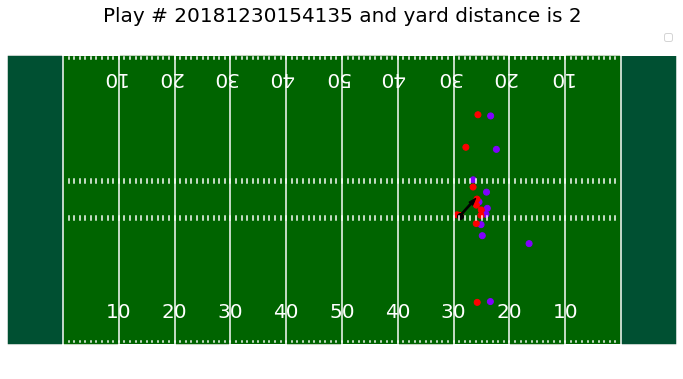

No handles with labels found to put in legend.


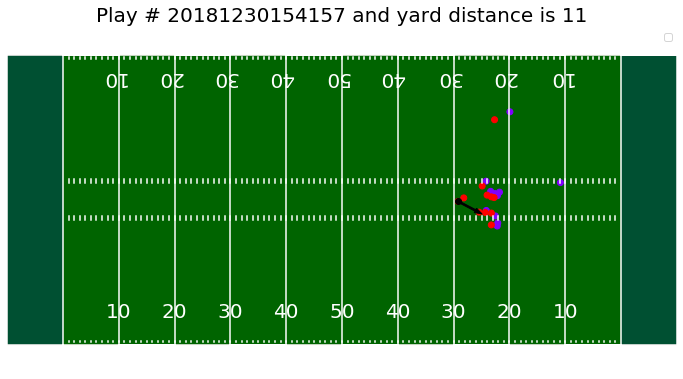

In [108]:
play_samples = list(train_df[train_df.ToLeft].PlayId.unique()[-3:]) + list(train_df[~train_df.ToLeft].PlayId.unique()[-3:])
for play_id in play_samples:
    show_play(play_id)

In [109]:
train_df['TeamOnOffense'] = "home"
train_df.loc[train_df.PossessionTeam != train_df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
train_df['IsOnOffense'] = train_df.Team == train_df.TeamOnOffense # Is player on offense?
train_df['YardLine_std'] = 100 - train_df.YardLine
train_df.loc[train_df.FieldPosition.fillna('') == train_df.PossessionTeam,  
          'YardLine_std'
         ] = train_df.loc[train_df.FieldPosition.fillna('') == train_df.PossessionTeam,  
          'YardLine']
train_df['X_std'] = train_df.X
train_df.loc[train_df.ToLeft, 'X_std'] = 120 - train_df.loc[train_df.ToLeft, 'X'] 
train_df['Y_std'] = train_df.Y
train_df.loc[train_df.ToLeft, 'Y_std'] = 160/3 - train_df.loc[train_df.ToLeft, 'Y'] 
train_df['Orientation_std'] = train_df.Orientation
train_df.loc[train_df.ToLeft, 'Orientation_std'] = np.mod(180 + train_df.loc[train_df.ToLeft, 'Orientation_std'], 360)
train_df['Dir_std'] = train_df.Dir
train_df.loc[train_df.ToLeft, 'Dir_std'] = np.mod(180 + train_df.loc[train_df.ToLeft, 'Dir_std'], 360)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in remainder
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in remainder
  app.launch_new_instance()


In [110]:
def show_play_std(play_id, train=train_df):
    df = train_df[train_df.PlayId == play_id]
    YardLine = df.YardLine_std.values[0]
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine,
                                   )
    ax.scatter(df.X_std, df.Y_std, cmap='rainbow', c=~df.IsOnOffense)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black')
    yards_covered = rusher_row["Yards"].values[0]

    x = rusher_row["X_std"].values[0]
    y = rusher_row["Y_std"].values[0]
    rusher_dir = rusher_row["Dir_std"].values[0]
    rusher_speed = rusher_row["S"].values[0]
    dx, dy = get_dx_dy(rusher_dir, rusher_speed)

    ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color='black')
    plt.title(f'Play # {play_id} and yard distance is {yards_covered} and scrimage is {YardLine}', fontsize=20)
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


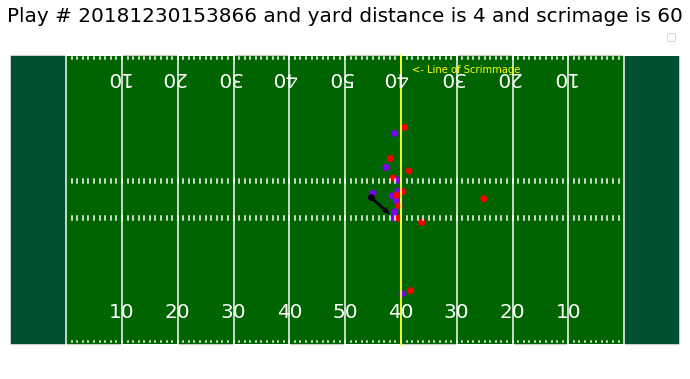

No handles with labels found to put in legend.


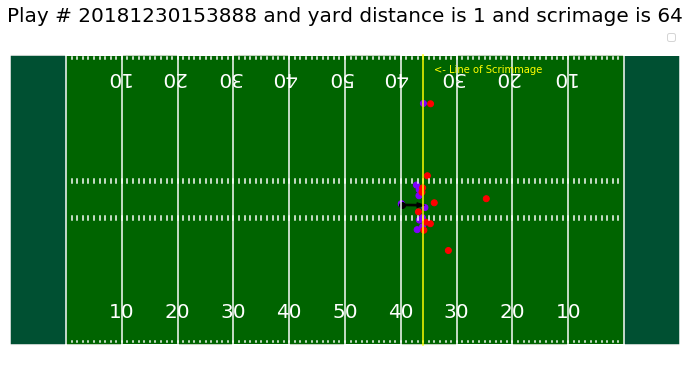

No handles with labels found to put in legend.


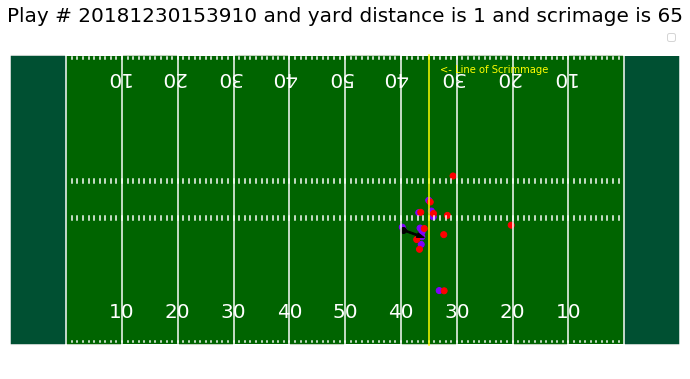

No handles with labels found to put in legend.


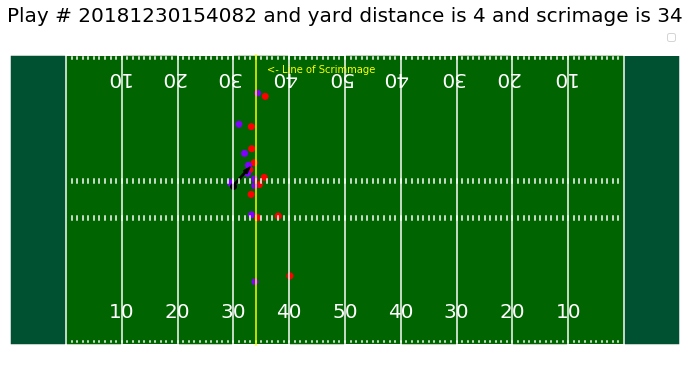

No handles with labels found to put in legend.


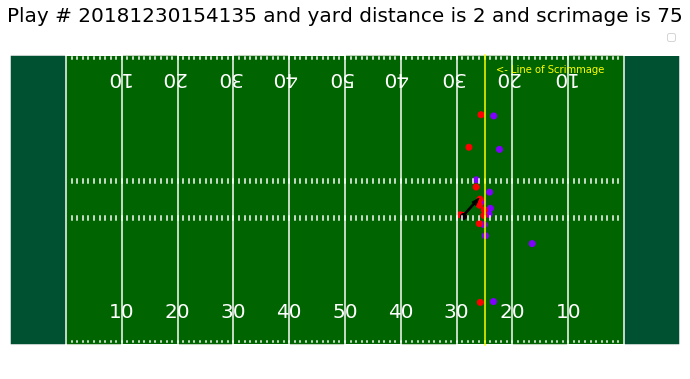

No handles with labels found to put in legend.


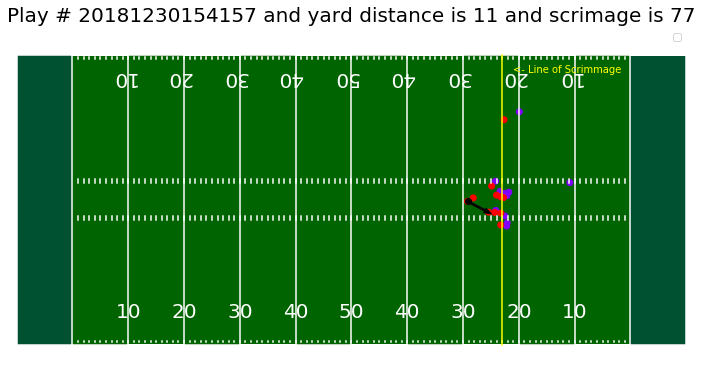

In [111]:
for play_id in play_samples:
    show_play_std(play_id)

No handles with labels found to put in legend.


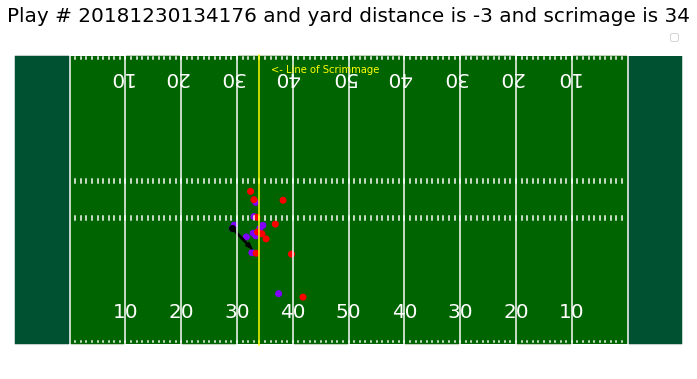

No handles with labels found to put in legend.


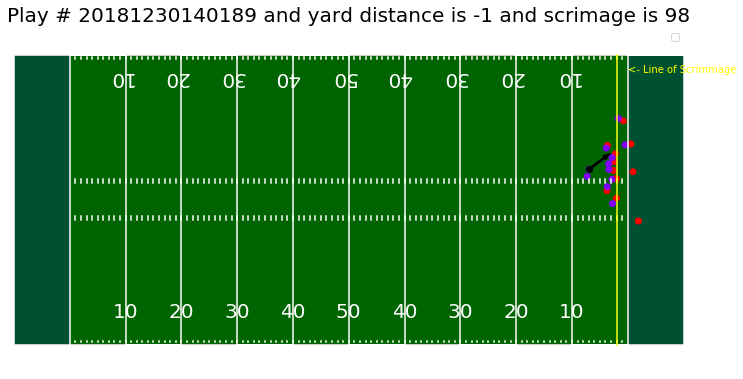

No handles with labels found to put in legend.


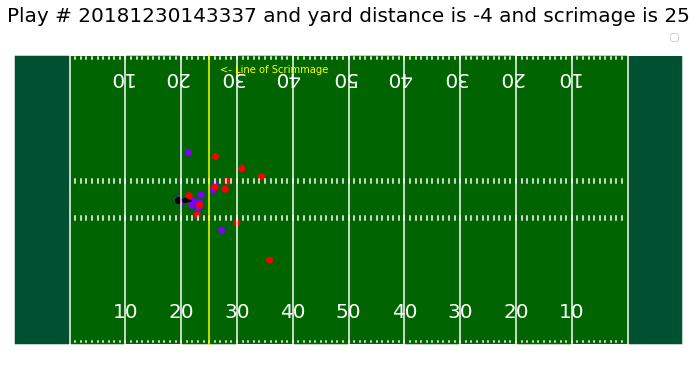

No handles with labels found to put in legend.


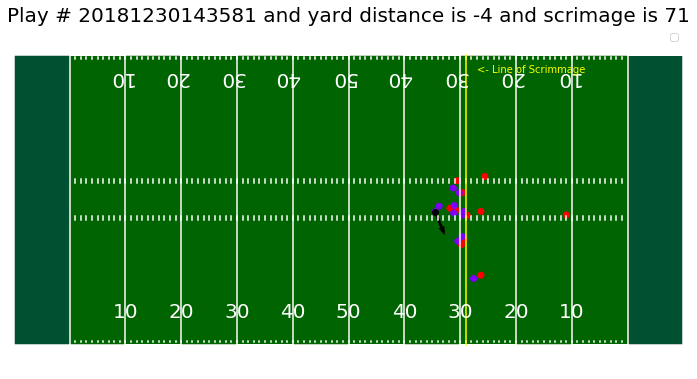

No handles with labels found to put in legend.


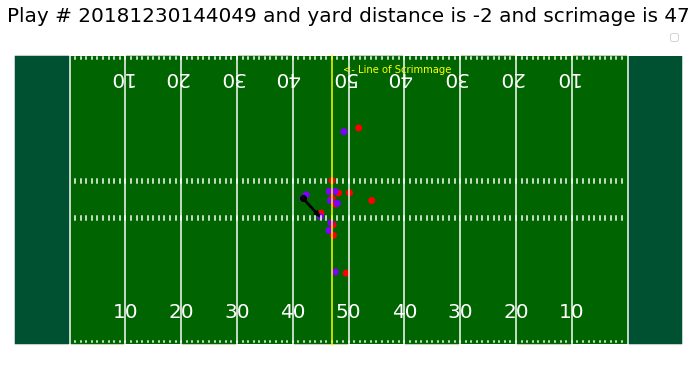

No handles with labels found to put in legend.


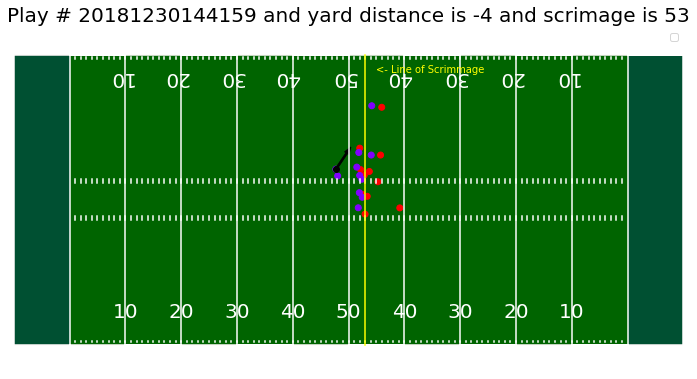

No handles with labels found to put in legend.


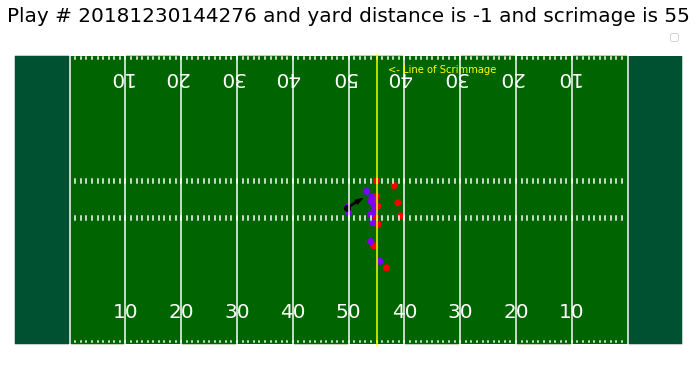

No handles with labels found to put in legend.


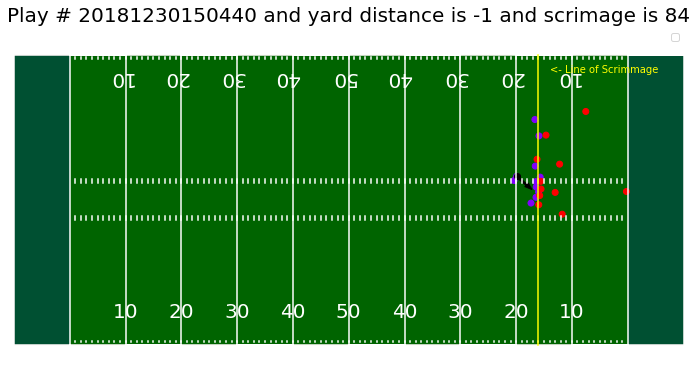

No handles with labels found to put in legend.


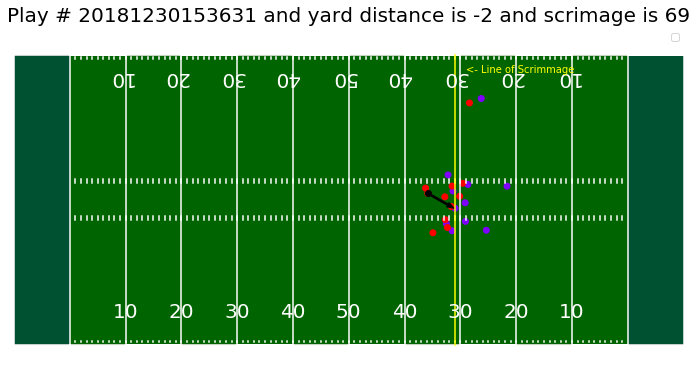

In [112]:
# distance to scrimage line is usefull to predict negative yard
play_samples_negtive = list(train_df[train_df['Yards']< 0].PlayId.unique()[-9:])
for play_id in play_samples_negtive:
    show_play_std(play_id)

No handles with labels found to put in legend.


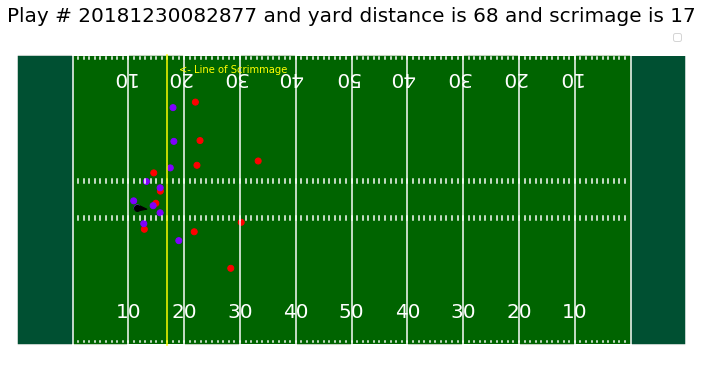

No handles with labels found to put in legend.


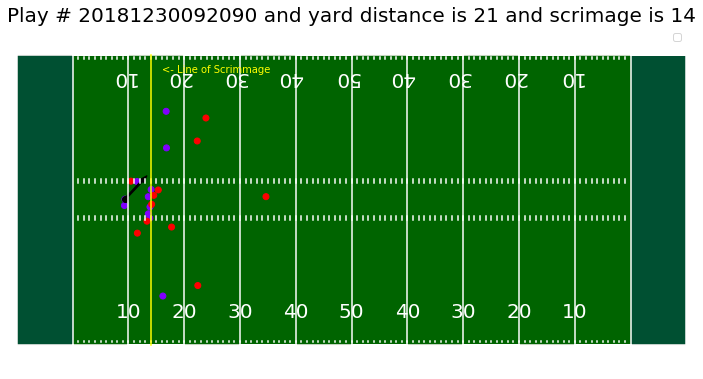

No handles with labels found to put in legend.


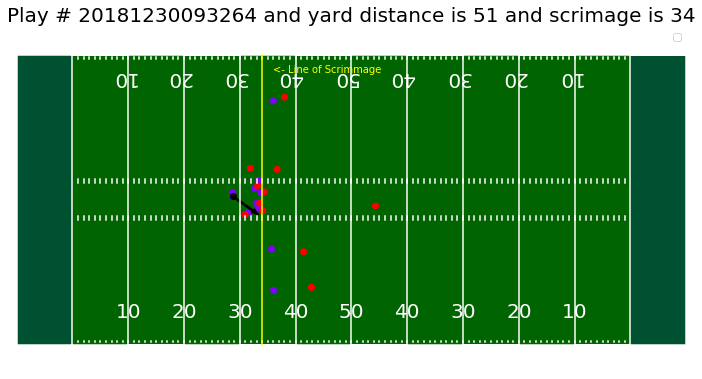

No handles with labels found to put in legend.


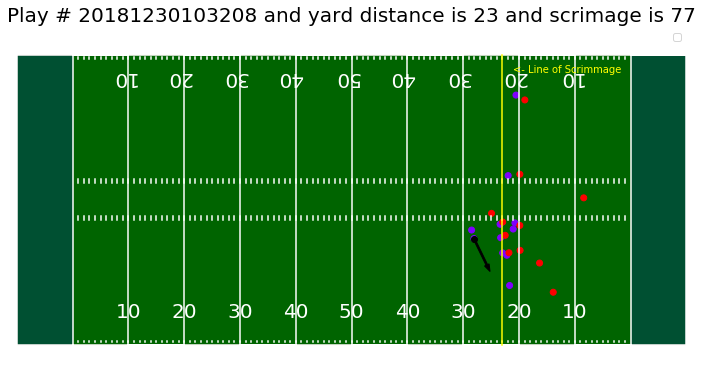

No handles with labels found to put in legend.


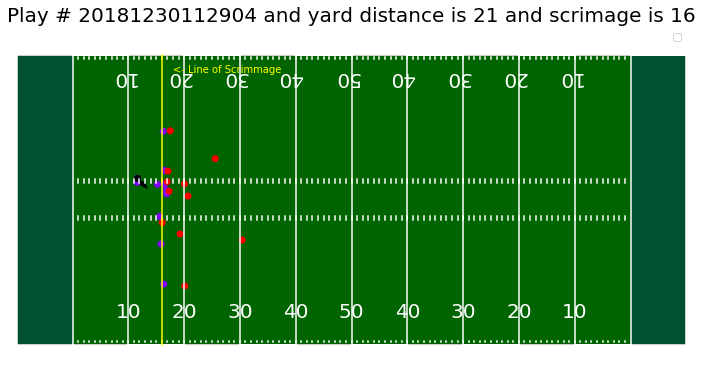

No handles with labels found to put in legend.


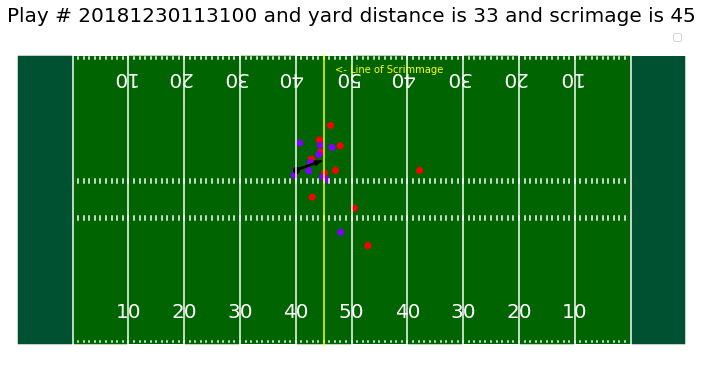

No handles with labels found to put in legend.


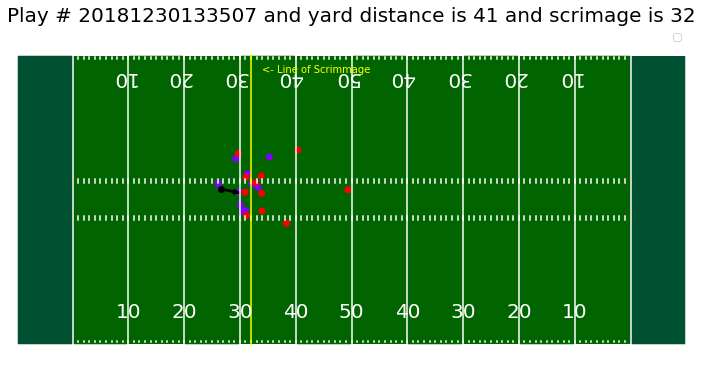

No handles with labels found to put in legend.


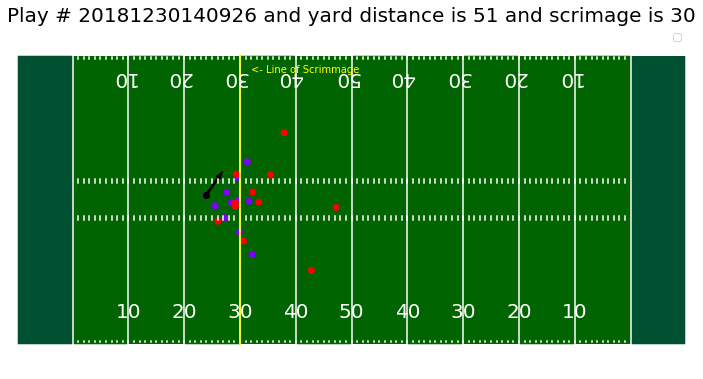

No handles with labels found to put in legend.


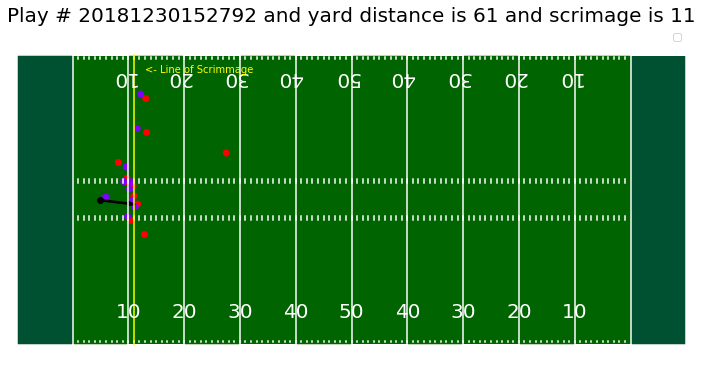

In [113]:
play_samples_large = list(train_df[train_df['Yards']> 20].PlayId.unique()[-9:])
for play_id in play_samples_large:
    show_play_std(play_id)

In [115]:
train_df[(train_df['PlayId'] == 20170907000118) & train_df['IsBallCarrier']]['Dir'].values

array([245.74])

In [133]:
for playid in train_df['PlayId'].unique():
    train_df.loc[train_df['PlayId']== playid,'angle_to_rusher'] = (np.abs(train_df.loc[train_df['PlayId']== playid,'Dir'] - train_df.loc[(train_df['PlayId'] == playid) & train_df['IsBallCarrier'],'Dir'].values)<=180) \
    & (np.abs(train_df.loc[train_df['PlayId']== playid,'Dir'] - train_df.loc[(train_df['PlayId'] == playid) & train_df['IsBallCarrier'],'Dir'].values)>=90)

In [126]:
train_df['face_to_rusher'] = (90 - train_df['Orientation_std']<=90) & (90 - train_df['Orientation_std']>= -90)

In [140]:
train_df.loc[train_df['PlayId'] ==20181230103208, 'Humidity']

504064    73.0
504065    73.0
504066    73.0
504067    73.0
504068    73.0
504069    73.0
504070    73.0
504071    73.0
504072    73.0
504073    73.0
504074    73.0
504075    73.0
504076    73.0
504077    73.0
504078    73.0
504079    73.0
504080    73.0
504081    73.0
504082    73.0
504083    73.0
504084    73.0
504085    73.0
Name: Humidity, dtype: float64